# 1. Data

In [1]:
import numpy as np
import pathlib

np.random.seed()

## 1.1 PrefLib Data

Profiles in PrefLib data do not have a consistent candidate set so we group profiles by the number of candidates.

In [2]:
preflib_profiles = {}

for path in pathlib.Path('preflib').glob('*.soc'):
    with open(path, 'r') as soc:
        lines = soc.read().splitlines()
        n_candidates = int(lines.pop(0))
        if n_candidates not in preflib_profiles:
            preflib_profiles[n_candidates] = []
        candidates = [lines.pop(0) for _ in range(n_candidates)]
        n_voters, vote_count, unique_orders = map(int, lines.pop(0).split(','))
        profile = []
        for _ in range(unique_orders):
            order = list(map(int, lines.pop(0).split(',')))
            for i in range(order[0]):
                profile.append(np.array(order[1:]) - 1)  # Count candidates from 0
        preflib_profiles[n_candidates].append(np.array(profile))

We filter profile groups that have less than 3 profiles.

In [3]:
preflib_profiles = {k: v for k, v in preflib_profiles.items() if len(v) >= 3}

## 1.2 Synthetic Data

For every profile group in PrefLib data we synthesize a random profile group with the same amount of candidates.

In [4]:
n_profiles = 200
n_voters = 20

synthetic_profiles = {}

# Generate random preferences
for n_candidates in preflib_profiles:
    synthetic_profiles[n_candidates] = []
    for _ in range(n_profiles):
        profile = np.empty((n_voters, n_candidates), dtype=int)
        for v in range(n_voters):
            profile[v] = np.random.permutation(n_candidates)
        synthetic_profiles[n_candidates].append(profile)

## 1.3 Train/Test Split

We can now use the synthetic data to learn the voting rules and test them on the PrefLib data.

In [5]:
dataset_candidates = sorted(preflib_profiles.keys())
print('Candidates in every profile group: ', dataset_candidates)

Candidates in every profile group:  [3, 4, 18, 20, 23, 24, 67, 103, 115, 240, 242]


# 2. Scoring rules

Ties are broken in favor of the alternative that was ranked first by more voters; if several alternatives have maximal scores and were ranked first by the same number of voters, the tie is broken in favor of the alternative that was ranked second by more voters; and so on.

In [6]:
def tie_break(profile, scores):
    ranks = [scores]
    for i in range(profile.shape[1]):
        ranks.insert(0, np.bincount(profile[:, i], minlength=profile.shape[1]))
    # Sort by score, then by times ranked first place, then by times ranked second places and so forth
    return np.lexsort(ranks)[-1]

Apply the scoring rules:

Plurality: $\alpha=(1,0,\cdots,0)$

Borda: $\alpha=(m-1,m-2,\cdots,0)$

Veto: $\alpha=(1,\cdots,1,0)$

In [7]:
data = {
    'synthetic': {},
    'preflib': {}
}

for n_candidates in dataset_candidates:
    data['synthetic'][n_candidates] = {}
    data['preflib'][n_candidates] = {}
    for name, profiles in (('synthetic', synthetic_profiles[n_candidates]), ('preflib', preflib_profiles[n_candidates])):
        for rule in ('plurality', 'borda', 'veto'):
            data[name][n_candidates][rule] = []
        for profile in profiles:
            plurality_winner = tie_break(profile, np.bincount(profile[:, 0], minlength=profile.shape[1]))
            borda_winner = tie_break(profile, np.sum(profile.shape[1] - 1 - np.argsort(profile), axis=0))
            veto_winner = tie_break(profile, -np.bincount(profile[:, -1], minlength=profile.shape[1]))
            data[name][n_candidates]['plurality'].append((profile, plurality_winner))
            data[name][n_candidates]['borda'].append((profile, borda_winner))
            data[name][n_candidates]['veto'].append((profile, veto_winner))

# 3. Learning

We implement Algorithm 1 as described in the paper, which returns a scoring rule that is consistent with the training examples.

Requires the CVXPY module for solving convex optimization, install with `pip install cvxpy`.

In [8]:
import cvxpy as cp

Solve the optimization problem:

$\forall{k}, \forall{x_j\in X_k}, \sum_{l}{\pi_{j_{k},l}^{k}{\alpha_l}}\geq\sum_{l}{\pi_{j,l}^{k}{\alpha_l}}+1$

$\forall{k}, \forall{x_j\notin X_k}, \sum_{l}{\pi_{j_{k},l}^{k}{\alpha_l}}\geq\sum_{l}{\pi_{j,l}^{k}{\alpha_l}}$

$\forall{l=1,...,m-1}, \alpha_l\geq\alpha_{l+1}$

$\forall{l}, \alpha_l\geq0$

Where $k$ is a training sample (profile, winner), $\pi_{j,l}^{k}$ is the number of voters that ranked alternative $x_j$ in place $l$ in sample $k$ and $x_{j_k}$ is the winning candidate in sample $k$. $x_j\in X_k$ iff ties are broken in favor of $x_j$ in sample $k$.

The vector $\alpha$ defines the scoring rule.

In [9]:
def consistent_voting_rule(profiles, n_candidates):
    score = cp.Variable(n_candidates)
    constraints = []
    for c in range(n_candidates - 1):
        constraints.append(score[c] >= score[c + 1])
    for c in range(n_candidates):
        constraints.append(score[c] >= 0)
    for k, (profile, winner) in enumerate(profiles):
        votes = np.apply_along_axis(lambda c: np.bincount(c, minlength=profile.shape[1]), 0, profile)
        # votes(i, j) -> How many times candidate i was voted in place j
        for candidate in range(n_candidates):
            if candidate == winner:
                continue
            vote_diff = votes[winner, :] - votes[candidate, :]
            tie = False
            for diff in vote_diff:
                if diff == 0:
                    continue
                if diff < 0:
                    tie = True # Ties are broken in favor of candidate
                break
            constraints.append(vote_diff @ score >= int(tie))
    problem = cp.Problem(cp.Minimize(cp.sum(score)), constraints)
    problem.solve(max_iters=300)
    return np.around(np.clip(score.value, 0, None), decimals=6)

# 4. Evaluation

In [10]:
import math
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def approximation_distance(data, rule):
    # The distance between voting rules is the fraction of preference profiles on which the two rules disagree
    n_disagree = 0
    for profile, winner in data:
        votes = np.apply_along_axis(lambda c: np.bincount(c, minlength=profile.shape[1]), 0, profile)
        # votes(i, j) -> How many times candidate i was voted in place j
        predicted_winner = tie_break(profile, votes @ rule)
        n_disagree += int(predicted_winner != winner)
    return n_disagree / len(data)

Learn scoring rules from synthetic data and measure error on PrefLib data, for every rule and candidate size.

This may take a few minutes to run.

In [12]:
train, test = data['synthetic'], data['preflib']
error = {}
for rule in ('plurality', 'borda', 'veto'):
    print(f'Evaluating {rule}')
    error[rule] = []
    for n_candidates in dataset_candidates:
        alpha = consistent_voting_rule(train[n_candidates][rule], n_candidates)
        error[rule].append(approximation_distance(test[n_candidates][rule], alpha))

Evaluating plurality
Evaluating borda
Evaluating veto


In [13]:
error_df = pd.DataFrame(error, index=dataset_candidates)
error_df

,plurality,borda,veto
3,0.0,0.000000,0.0
4,0.0,0.000000,0.0
18,0.0,0.000000,0.0
20,0.0,0.250000,0.0
23,0.0,0.166667,0.0
24,0.0,0.000000,0.0
67,0.0,0.000000,0.0
103,0.0,0.666667,0.0
115,0.0,0.333333,0.0
240,0.0,1.000000,0.0


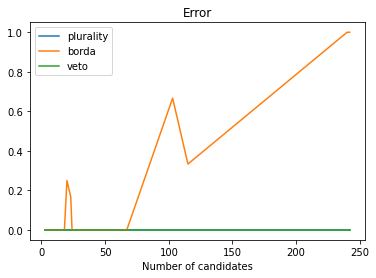

In [17]:
error_df.plot.line()
plt.title('Error')
plt.xlabel('Number of candidates')
plt.show()

The results show that the Plurality and Veto scoring rules were learnt correctly, while Borda had higher error rates on larger candidate sets. 

Note that larger candidate sets have a small amount of profiles (about 3 profiles) so the difference between an error rate of $\frac{1}{3}$ and $\frac{2}{3}$ or $\frac{2}{3}$ and $1$ is one profile.

We can conclude from the results that we need more training examples for the larger candidate sets to learn the Borda scoring rule efficiently, while a small training set suffices to learn the Plurality and Veto scoring rules.